In [4]:
import sys, os
from tqdm import tqdm
from PIL import Image
import json
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import sys
from typing import *
import numpy as np
import matplotlib.pyplot as plt


sys.path.append(os.getcwd())

In [5]:
class IMDBDataset(Dataset):
    """Implements a torch Dataset class for the imdb dataset."""
    
    def __init__(self, file: h5py.File, start_ind: int, end_ind: int, vggfeature: bool = False) -> None:
        """Initialize IMDBDataset object.

        Args:
            file (h5py.File): h5py file of data
            start_ind (int): Starting index for dataset
            end_ind (int): Ending index for dataset
            vggfeature (bool, optional): Whether to return pre-processed vgg_features or not. Defaults to False.
        """
        self.file = file
        self.start_ind = start_ind
        self.size = end_ind-start_ind
        self.vggfeature = vggfeature

    def __getitem__(self, ind):
        """Get item from dataset.

        Args:
            ind (int): Index of data to get

        Returns:
            tuple: Tuple of text input, image input, and label
        """
        if not hasattr(self, 'dataset'):
            self.dataset = h5py.File(self.file, 'r')
        text = self.dataset["features"][ind+self.start_ind]
        image = self.dataset["images"][ind+self.start_ind] if not self.vggfeature else \
            self.dataset["vgg_features"][ind+self.start_ind]
        label = self.dataset["genres"][ind+self.start_ind]

        return text, image, label

    def get_item_by_id(self, imdb_id: str):
        """Get item from dataset by imdb_id.

        Args:
            imdb_id (str): IMDB ID to get
        """
        text = self.dataset["features"][self.dataset["imdb_ids"].index(imdb_id)]
        image = self.dataset["images"][self.dataset["imdb_ids"].index(imdb_id)] if not self.vggfeature else \
            self.dataset["vgg_features"][self.dataset["imdb_ids"].index(imdb_id)]
        label = self.dataset["genres"][self.dataset["imdb_ids"].index(imdb_id)]
        return text, image, label
    
    def get_raw(self, imdb_id, file_path):
        # REad from the the file, based on the imdb_id
        imdb_id = str(imdb_id[2:-1])
        file_name = file_path + '/' + imdb_id + '.json'
        with open(file_name, 'r') as f:
            data = json.load(f)
        text = data['plot']
        image = Image.open(file_path + '/' + imdb_id + '.jpeg')
        return text, image

    def __len__(self):
        """Get length of dataset."""
        return self.size

In [6]:
def get_dataloader(path: str, test_path: str, num_workers: int = 8, train_shuffle: bool = True, batch_size: int = 40, vgg: bool = False, skip_process=False, no_robust=False):
    """Get dataloaders for IMDB dataset.

    Args:
        path (str): Path to training datafile.
        test_path (str): Path to test datafile.
        num_workers (int, optional): Number of workers to load data in. Defaults to 8.
        train_shuffle (bool, optional): Whether to shuffle training data or not. Defaults to True.
        batch_size (int, optional): Batch size of data. Defaults to 40.
        vgg (bool, optional): Whether to return raw images or pre-processed vgg features. Defaults to False.
        skip_process (bool, optional): Whether to pre-process data or not. Defaults to False.
        no_robust (bool, optional): Whether to not use robustness measures as augmentation. Defaults to False.

    Returns:
        Tuple[Dict]: Tuple of Training dataloader, Validation dataloader, Test Dataloader
    """
    train_dataloader = DataLoader(IMDBDataset(path, 0, 15552, vgg),
                                  shuffle=train_shuffle, num_workers=num_workers, batch_size=batch_size)
    val_dataloader = DataLoader(IMDBDataset(path, 15552, 18160, vgg),
                                shuffle=False, num_workers=num_workers, batch_size=batch_size)
    if no_robust:
        test_dataloader = DataLoader(IMDBDataset(path, 18160, 25959, vgg),
                                     shuffle=False, num_workers=num_workers, batch_size=batch_size)
        return train_dataloader, val_dataloader, test_dataloader


In [7]:
traindata, validdata, testdata = get_dataloader("./data/multimodal_imdb.hdf5", "./data/mmimdb", vgg=True, batch_size=128, no_robust=True)

In [8]:
print(len(traindata), len(validdata), len(testdata))

122 21 61


In [10]:
file = 'data/multimodal_imdb.hdf5'
dataset = h5py.File(file, 'r')

<KeysViewHDF5 ['features', 'genres', 'images', 'imdb_ids', 'sequences', 'three_grams', 'vgg_features', 'word_grams']>
(3, 256, 160)
(13253,)
b'0028219'


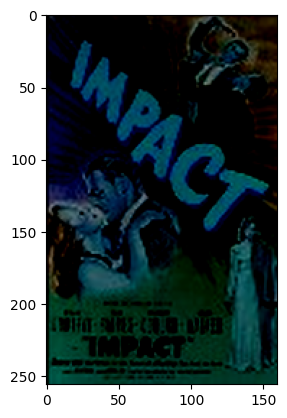

In [11]:
len(dataset['features']), len(dataset['images']), len(dataset['vgg_features']), len(dataset['genres'])

print(dataset.keys())

len(dataset['sequences'])

print(dataset['images'][0].shape)

#Shift the first axis to the last axis
img = np.moveaxis(dataset['images'][93], 0, -1)
plt.imshow(img)

dataset.keys()
print(dataset['word_grams'][0].shape)
print(dataset['imdb_ids'][0])

In [12]:
print(dataset['features'].shape)

(25959, 300)


In [13]:
file_path = 'data/mmimdb/dataset'

imdb_id = str(dataset['imdb_ids'][0])
print(imdb_id)


#Extract numerical part of b'9099'
imdb_id = imdb_id[2:-1]
print(imdb_id)
file_name = file_path + '/' + imdb_id + '.json'

with open(file_name, 'r') as f:
    data = json.load(f)


print(data['plot'])

b'0028219'
0028219
["Sardonic detective Shane, thrown out of one town for bringing trouble, heads for home and his ex-partner's detective agency. The business is in a sad way, and Shane, who has had the forethought to provide himself with a 250-dollar commission from an old lady on the train, is welcomed with open arms. When pretty Valerie Purvis walks in the next day willing to pay over the odds to put a tail on the man who did her wrong, Shane's way with the ladies looks like paying off yet again. But things start to go wrong when his partner is murdered, and Shane himself comes home to find his apartment wrecked by a gentlemanly crook who comes back to apologise -- and to tell him a fascinating fairy-story about the fabled Horn of Roland that looks like not being so mythical after all. Miss Purvis wants protection. The police want answers. And all sorts of people want the 'French horn'... but Shane is one jump ahead of everyone all the way. Well, almost."]


In [14]:
file = '../../../data/multimodal_imdb.hdf5'
dataset = IMDBDataset(file, 0, 15552, vggfeature=True)

In [15]:
print(type(dataset))

print(dataset.get_raw("b\'0092501\'", 'data/mmimdb/dataset'))

<class '__main__.IMDBDataset'>
(['Dragon Ma is back, having rid the seas of the dreaded Pirate Lo. Back on land, he is assigned to the police force, where he is to clean up corruption and crime in a local suburb. Along the way, he is caught up in the fate of several Chinese patriots attempting to secure sympathy and support for their revolutionary cause. The Chinese Manchu government is after these revolutionaries, and anyone that stands in their way is in trouble, even if they are in the police force.', 'Dragon is now transferred to be the police head of Sai Wan district, and has to contend with a gangster kingpin, anti-Manchu revolutionaries, some runaway pirates, Manchu Loyalists and a corrupt police superintendent.'], <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=332x475 at 0x7F508B571588>)


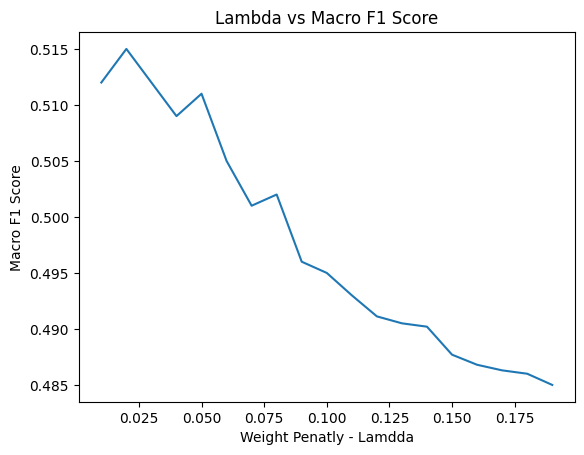

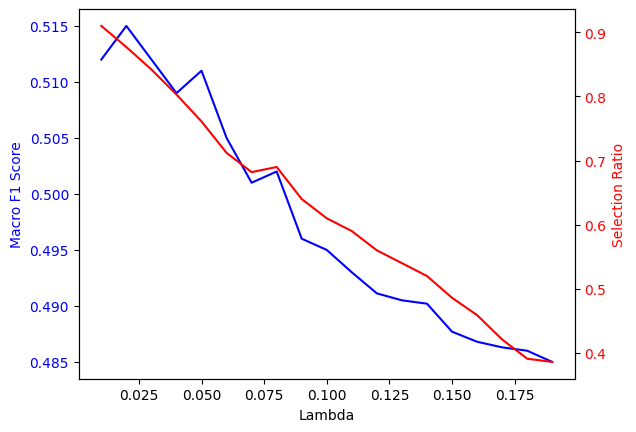

In [24]:

#Base Network

lambas = [x*0.01 for x in range(1, 20)]

macro_F1s = [0.512, 0.515, 0.512, 0.509, 0.511, 0.505, 0.501, 0.502, 0.496, 0.495, 0.493, 0.49112, 0.4905, 0.4902, 0.4877, 0.4868, 0.4863, 0.486, 0.485]

selection_ratios = [0.91, 0.877, 0.842, 0.803, 0.761, 0.712, 0.682, 0.69, 0.64, 0.61, 0.59, 0.56, 0.54, 0.52, 0.486, 0.459, 0.421, 0.391, 0.386]

# selection_ratios = []

import matplotlib.pyplot as plt


plt.plot(lambas, macro_F1s)
plt.xlabel('Weight Penatly - Lamdda')
plt.ylabel('Macro F1 Score')
plt.title('Lambda vs Macro F1 Score')
plt.show()


# Do an SNS plot; Show the selection ratio on the right y-axis
import seaborn as sns

fig, ax1 = plt.subplots()
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Macro F1 Score', color='b')
ax1.plot(lambas, macro_F1s, color='b')
ax1.tick_params(axis='y', labelcolor='b')

#Plot selection ratio on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Selection Ratio', color='r')
ax2.plot(lambas, selection_ratios, color='r')
ax2.tick_params(axis='y', labelcolor='r')




In [16]:
# !pip install seaborn

In [ ]:
# Results for count flops
# Model 0 = Text encoder 689.66400K 691.22300K
# Model 1 = CNN encoder 48.66731M 4.33759M
# Model 2 = late fusion 10.32005M 10.31128M

# Results for inclusion of CNN image encoder

# reg = 0.2
# Test f1 micro 48.79 ± 0.00 | f1 macro 36.54 ± 0.00 | Flop saving 25.17 ± 0.00M | Branch selection ratio 0.387 ± 0.000
# Best result [ 0.48785756  0.36543537 25.16919327]

# reg = 0.175
# Test f1 micro 51.19 ± 0.00 | f1 macro 39.15 ± 0.00 | Flop saving 22.47 ± 0.00M | Branch selection ratio 0.317 ± 0.000
# Best result [ 0.51192666  0.39151393 22.47470093]

# reg = 0.15
# Test f1 micro 53.22 ± 0.00 | f1 macro 40.90 ± 0.00 | Flop saving 19.02 ± 0.00M | Branch selection ratio 0.227 ± 0.000
# Best result [ 0.53221728  0.40903116 19.02300262]

# reg = 0.125
# Test f1 micro 49.40 ± 0.00 | f1 macro 37.88 ± 0.00 | Flop saving 24.03 ± 0.00M | Branch selection ratio 0.358 ± 0.000
# Best result [ 0.49403299  0.37875806 24.03337669]

# reg = 0.11
# Test f1 micro 52.05 ± 0.00 | f1 macro 39.52 ± 0.00 | Flop saving 20.45 ± 0.00M | Branch selection ratio 0.264 ± 0.000
# Best result [ 0.5204808   0.39524118 20.45383453]

# reg = 0.1
# Test f1 micro 42.77 ± 0.00 | f1 macro 28.45 ± 0.00 | Flop saving 33.14 ± 0.00M | Branch selection ratio 0.595 ± 0.000
# Best result [ 0.4277162   0.28445537 33.14448929]

# reg = 0.075
# Test f1 micro 53.60 ± 0.00 | f1 macro 42.97 ± 0.00 | Flop saving 18.70 ± 0.00M | Branch selection ratio 0.218 ± 0.000
# Best result [ 0.53604715  0.42974606 18.69848251]

# reg = 0.05
# Test f1 micro 40.35 ± 0.00 | f1 macro 25.31 ± 0.00 | Flop saving 36.69 ± 0.00M | Branch selection ratio 0.688 ± 0.000
# Best result [ 0.40349479  0.25312253 36.68960953]

# reg = 0.025
# Test f1 micro 40.21 ± 0.00 | f1 macro 25.72 ± 0.00 | Flop saving 38.84 ± 0.00M | Branch selection ratio 0.744 ± 0.000
# Best result [ 0.40210327  0.25723708 38.83831406]

# reg = 0.01
# Test f1 micro 37.92 ± 0.00 | f1 macro 22.32 ± 0.00 | Flop saving 41.47 ± 0.00M | Branch selection ratio 0.812 ± 0.000
# Best result [ 0.37920417  0.22319715 41.46888351]

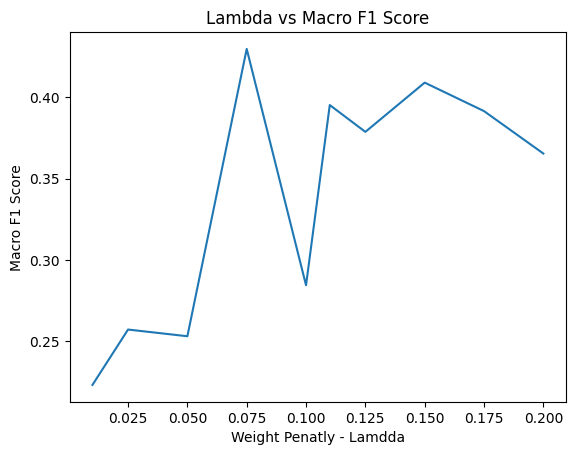

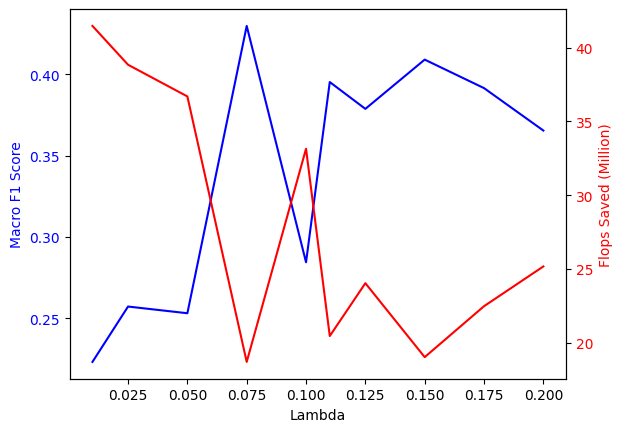

In [17]:
lambdas = [0.2, 0.175, 0.15, 0.125, 0.11, 0.1, 0.075, 0.05, 0.025, 0.01]

macro_F1s = [0.36543537, 0.39151393, 0.40903116, 0.37875806, 0.39524118, 0.28445537, 0.42974606, 0.25312253, 0.25723708, 0.22319715]

flops_saved = [25.16919327, 22.47470093, 19.02300262, 24.03337669, 20.45383453, 33.14448929, 18.69848251, 36.68960953, 38.83831406, 41.46888351]

# Plot the results

import matplotlib.pyplot as plt

plt.plot(lambdas, macro_F1s)
plt.xlabel('Weight Penatly - Lamdda')
plt.ylabel('Macro F1 Score')
plt.title('Lambda vs Macro F1 Score')
plt.show()

# Do an SNS plot

import seaborn as sns

fig, ax1 = plt.subplots()
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Macro F1 Score', color='b')
ax1.plot(lambdas, macro_F1s, color='b')
ax1.tick_params(axis='y', labelcolor='b')

#Plot selection ratio on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Flops Saved (Million)', color='r')
ax2.plot(lambdas, flops_saved, color='r')
ax2.tick_params(axis='y', labelcolor='r')

In [30]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
sys.path.append(os.getcwd())
from datasets_1.imdb.get_data import get_dataloader # type: ignore
from unimodals.common_models import MLP, Linear, MaxOut_MLP
from fusions.common_fusions import Concat
from training_structures.Supervised_Learning import train, test, MMDL


def DiffSoftmax(logits, tau=1.0, hard=False, dim=-1):
    y_soft = (logits / tau).softmax(dim)
    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret


class DynMMNet(nn.Module):
    def __init__(self, branch_num=3, pretrain=True, freeze=True, file_path='./log/imdb/default_run/'):
        super(DynMMNet, self).__init__()
        self.branch_num = branch_num
        
        self.branch1_encoder_path = file_path + 'encoder_text.pt'
        self.branch1_head_path = file_path + 'head_text.pt'
        self.branch2_encoder_path = file_path + 'encoder_image.pt'
        self.branch2_head_path = file_path + 'head_image.pt'
        self.branch3_model_path = file_path + 'best_lf.pt'
        
        
        # branch 1: text network
        self.text_encoder = torch.load(self.branch1_encoder_path) if pretrain else MLP(300, 512, 512)
        self.text_head = torch.load(self.branch1_head_path) if pretrain else MLP(512, 512, 23)
        # self.branch1 = nn.Sequential(self.text_encoder, self.text_head)

        # branch2: image network, discard this branch due to poor performance
        # self.image_encoder = torch.load(self.branch2_encoder_path) if pretrain else MLP(4096, 1024, 512)
        # self.image_head = torch.load(self.branch2_head_path) if pretrain else MLP(512, 512, 23)
        # self.branch2 = nn.Sequential(self.image_encoder, self.image_head)

        # branch3: text+image late fusion 
        if pretrain:
            self.branch3 = torch.load(self.branch3_model_path)
        else:
            encoders = [MaxOut_MLP(512, 512, 300, linear_layer=False), MaxOut_MLP(512, 1024, 4096, 512, False)]
            head = Linear(1024, 23)
            fusion = Concat()
            self.branch3 = MMDL(encoders, fusion, head, has_padding=False)

        if freeze:
            self.freeze_branch(self.text_encoder)
            self.freeze_branch(self.text_head)
            # self.freeze_branch(self.image_encoder)
            # self.freeze_branch(self.image_head)
            self.freeze_branch(self.branch3)

        # gating network
        self.gate = MLP(4396, 128, branch_num)
        self.temp = 1
        self.hard_gate = True
        self.weight_list = torch.Tensor()
        self.store_weight = False
        self.infer_mode = 0
        self.flop = torch.Tensor([1.25261, 7.56771, 10.86908])

    def freeze_branch(self, m):
        for param in m.parameters():
            param.requires_grad = False

    def reset_weight(self):
        self.weight_list = torch.Tensor()
        self.store_weight = True

    def weight_stat(self):
        # print(self.weight_list)
        tmp = torch.mean(self.weight_list, dim=0)
        print(f'mean branch weight {tmp[0].item():.4f}, {tmp[1].item():.4f}, {tmp[2].item():.4f}')
        self.store_weight = False
        return tmp[1].item()

    def cal_flop(self):
        tmp = torch.mean(self.weight_list, dim=0)
        total_flop = (self.flop * tmp).sum()
        print(f'Total Flops {total_flop.item():.2f}M')
        return total_flop.item()

    def forward(self, inputs):
        x = torch.cat(inputs, dim=1)
        weight = DiffSoftmax(self.gate(x), tau=self.temp, hard=self.hard_gate)

        if self.store_weight:
            self.weight_list = torch.cat((self.weight_list, weight.cpu()))

        pred_list = [self.text_head(self.text_encoder(inputs[0])), self.branch3(inputs)]
        if self.infer_mode > 0:
            return pred_list[self.infer_mode - 1], 0

        output = weight[:, 0:1] * pred_list[0] + weight[:, 1:2] * pred_list[1] #+ weight[:, 2:3] * pred_list[2]
        return output, weight[:, 1].mean()

    def forward_separate_branch(self, inputs, path, weight_enable):  # see separate branch performance
        if weight_enable:
            x = torch.cat(inputs, dim=1)
            weight = DiffSoftmax(self.gate(x), tau=self.temp, hard=self.hard_gate)
        if path == 1:
            output = self.text_head(self.text_encoder(inputs[0]))
        elif path == 2:
            output = self.image_head(self.image_encoder(inputs[1]))
        else:
            output = self.branch3(inputs)

        return output


In [37]:
model = DynMMNet()


model_file_name = 'log/imdb/default_run/DynMMNet_freeze_True_reg_1.0.pt'

# model.load_state_dict(torch.load(model_file_name))
model = torch.load(model_file_name).cuda()
model.hard_gate = True
# Get the inputs from the IMDB Dataset

# def processinput(inp):
#     if input_to_float:
#         return inp.float()
#     else:
#         return inp

for i, (text, image, label) in enumerate(traindata):
    # Get the first text instance in the batch
    text = text[0].unsqueeze(0)
    image = image[0].unsqueeze(0)
    label = label[0].unsqueeze(0)
    inputs = [text, image]
    x = torch.cat(inputs, dim=1).cuda()
    selected_gate = model.gate(x)
    #Print before softmax
    print(selected_gate)
    selected_gate = DiffSoftmax(model.gate(x), tau=model.temp, hard=model.hard_gate)
    # out = model([text.cuda(), image.cuda()])
    print(selected_gate)
    break
    


# print(out)

tensor([[ 6.7531, -7.6846]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<AddBackward0>)


NameError: name 'plot' is not defined

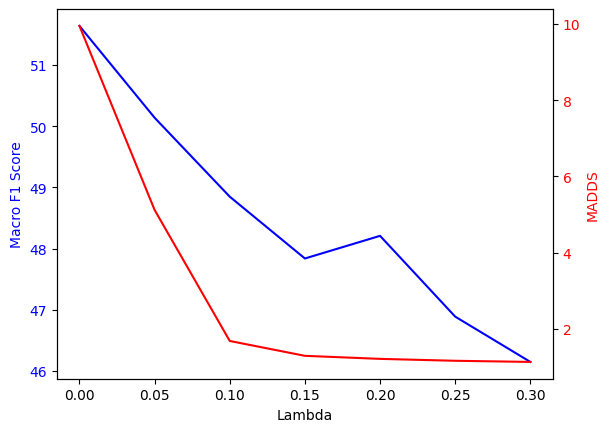

In [5]:
MADDS = [9.95, 5.12, 1.68, 1.29, 1.21, 1.16, 1.13]
MACRO_F1 =  [51.64, 50.14, 48.85, 47.84, 48.21, 46.89, 46.15]
LAAMBDA = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]


MACRO_F1_OURS = [50.34, 49.44, 50.33, 49.36, 49.12, 48.21, 47.84]
MADDS_OURS = [4.96, 4.61, 4.35, 4.23, 3.87, 3.56, 3.29] 

# Gate MLP + E1 + E2 All 61.21 51.64 9.95 0
# Gate MLP + E1 + E2 All 60.02 50.14 5.12 0.05
# Gate MLP + E1 + E2 All 59.48 48.85 1.68 0.10
# Gate MLP + E1 + E2 All 59.25 47.84 1.29 0.15
# Gate MLP + E1 + E2 All 59.12 48.21 1.21 0.20

#pLOT THESE WITH MADDS on the right Y Axis


import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Macro F1 Score', color='b')
ax1.plot(LAAMBDA, MACRO_F1, color='b')
ax1.tick_params(axis='y', labelcolor='b')

SAVINGS = [10.3 - madd for madd in MADDS]

#Plot selection ratio on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('MADDS', color='r')
ax2.plot(LAAMBDA, MADDS, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2/plot(LAAMBDA, SAVINGS, color='g')

#Plot savings on the right y-axis
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylabel('Flops Saved (Million)', color='g')
# ax3.plot(LAAMBDA, SAVINGS, color='g')
# ax3.tick_params(axis='y', labelcolor='g')




plt.show()


# Gate MLP + E1 + E5 59.61 50.34 4.96 0
# Gate MLP + E1 + E5 59.30 49.44 4.61 0.05
# Gate MLP + E1 + E5 59.55 50.33 4.96 0.1
# Gate MLP + E1 + E2 + E4 49.12 36.81 24.87 0.2


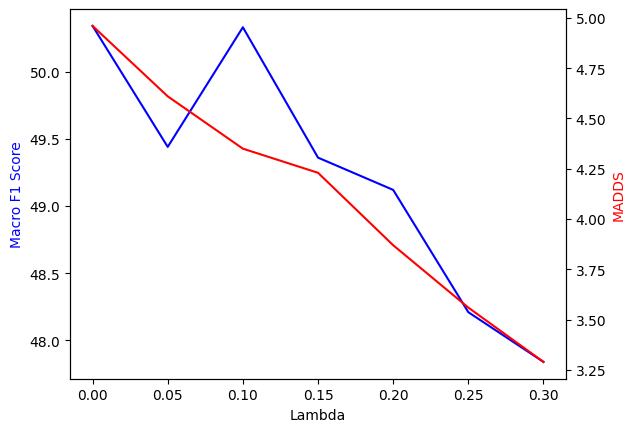

In [4]:
LAAMBDA = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
MACRO_F1_OURS = [50.34, 49.44, 50.33, 49.36, 49.12, 48.21, 47.84]
MADDS_OURS = [4.96, 4.61, 4.35, 4.23, 3.87, 3.56, 3.29] 


#plot the above

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Macro F1 Score', color='b')
ax1.plot(LAAMBDA, MACRO_F1_OURS, color='b')

#Plot selection ratio on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('MADDS', color='r')
ax2.plot(LAAMBDA, MADDS_OURS, color='r')

plt.show()